In [1]:
import numpy as np
from optyx.optyx import (
    DualRail,
    Bit,
    Mode,
    Swap
)
from optyx.zw import ZBox
from optyx.channel import (
    Channel,
    bit,
    qmode,
    Measure
)
from optyx.lo import Phase, BS_hadamard
from optyx.feed_forward.classical_control import (
    ClassicalFunctionBox,
    ControlChannel
)
from optyx.feed_forward.controlled_gates import (
    BitControlledBox,
)
from optyx.zx import Z

In [2]:
def fusion_i_function(x):
    """
    A classical function that returns two bits based on an input x,
    based on the classical logical for the Fusion type I circuit.
    """
    a = x[0]
    b = x[1]
    c = x[2]
    d = x[3]
    s = (a % 2) ^ (b % 2)
    k = int(s*(b + d) + (1-s)*(1 - (a + b)/2))%2
    return [not s, k]

classical_correction = ControlChannel(
    ClassicalFunctionBox(
        fusion_i_function,
        Mode(4),
        Bit(2)
    )
)

correction = Channel(
    "Phase Correction",
    BitControlledBox(
        Phase(0.5) @ Mode(1)
    ),
    dom = bit @ qmode**2
)

fusion_failure_processing = Channel(
    "Fusion Failure Processing",
    BitControlledBox(
        ZBox(1, 1, lambda i: 0) @ Mode(1)
    ),
    dom = bit @ qmode**2
)

kraus_fusion = (
    Mode(1) @ Swap(Mode(1), Mode(1)) @ Mode(1) >>
    Mode(1) @ BS_hadamard @ Mode(1) >>
    Swap(Mode(1), Mode(1)) @ Mode(1) @ Mode(1) >>
    Mode(1) @ Swap(Mode(1), Mode(1)) @ Mode(1) >>
    Mode(1) @ Mode(1) @ BS_hadamard
)

fusion = Channel(
    "Fusion",
    kraus_fusion
)

In [3]:
prep = (
    DualRail() @ Z(0, 2) >>
    Mode(2) @ DualRail() @ DualRail()
)

channel_prep = Channel(
    "Preparation",
    prep
)

teleportation = (
    channel_prep >>
    fusion @ qmode**2 >>
    Measure(qmode**4) @ qmode**2 >>
    classical_correction @ qmode**2 >>
    bit @ correction >>
    fusion_failure_processing >>
    Channel("DR", DualRail().dagger())
)

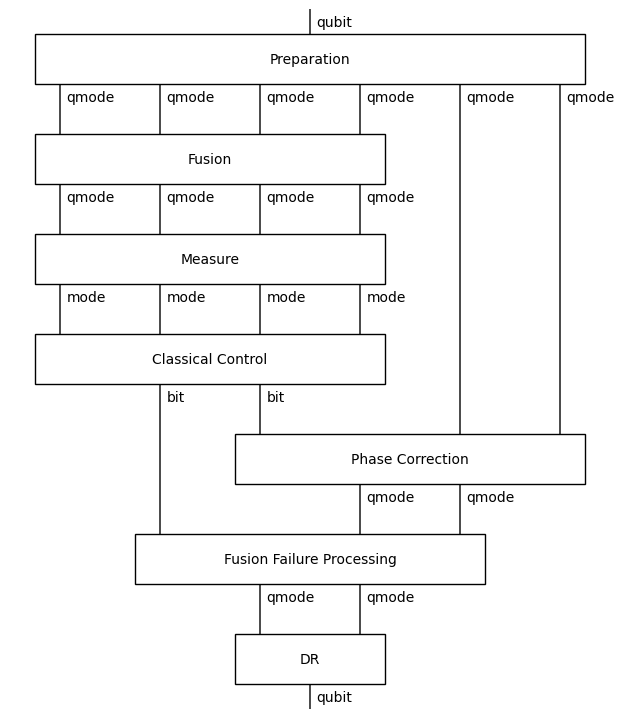

In [4]:
teleportation.foliation().draw()

In [5]:
array_teleportation = teleportation.double().to_zw().to_tensor().eval().array

In [6]:
from optyx.optyx import Id

array_id = Channel("Identity", Id(Bit(1))).double().to_zw().to_tensor().eval().array

In [7]:
np.allclose(array_teleportation, array_id)

True